# [Deepspeed](https://github.com/microsoft/DeepSpeed)
- DeepSpeed1는 `마이크로소프트`에서 개발한 오픈 소스 딥러닝 최적화 라이브러리입니다.
- 이 라이브러리는 대규모 모델, 특히 자연어 처리(NLP)를 위한 대규모 언어 모델 학습의 효율성과 속도를 대폭 개선합니다.
- DeepSpeed는 모델 학습을 더 빠르고 비용 효율적으로 만들기 위해 설계되었으며, 이를 통해 개발자와 연구자들은 기존 하드웨어에서도 매우 큰 모델을 효율적으로 학습할 수 있습니다.
- DeepSpeed의 고유한 효율성 및 효율성 이점을 활용하여 `PyTorch 모델`에 대한 몇 줄의 코드 변경만으로 속도와 확장성을 높일 수 있다.

## 주요 기능
- `모델 분할`: DeepSpeed는 모델 분할을 통해 단일 GPU 메모리 한계를 넘어서는 매우 큰 모델을 학습할 수 있도록 지원합니다.
- `효율적인 데이터 병렬 처리`: GPU에서의 데이터 병렬 처리를 최적화하여, 학습 속도를 개선합니다.
- `ZeRO 최적화`: ZeRO(ZeRO-Redundancy Optimizer) 기술을 사용해 메모리 사용량을 줄이면서 대규모 모델의 학습을 가능하게 합니다.
- `모델 학습 가속`: 커널 최적화와 효율적인 커뮤니케이션을 통해 모델 학습 속도를 높입니다.

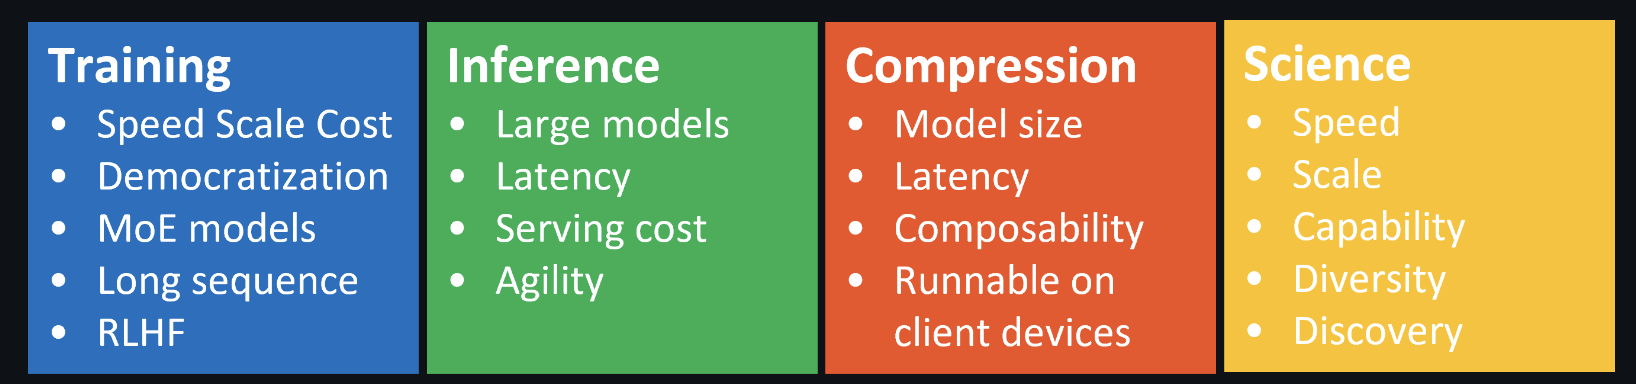

## DeepSpeed의 ZeRO(Zero Redundancy Optimizer)
- 기존의 딥러닝 모델의 분산 학습(DDP)에서는 모든 GPU가 모델을 가지고 있어야 했기 때문에 모델을 학습시키기 위한 값(Optimizer State, Gradient, Parameter)을 GPU마다 복제해서 가지고 있어야 했다.
- GPT-2 모델은 3GB 정도의 메모리를 차지하지만 32GB GPU에서 학습이 안되는 것이 이러한 낭비 문제 때문이었다.
- ZeRO는 이러한 모델(파라미터) 복제로 인한 낭비를 해결한다.

DeepSpeed의 ZeRO는 stage를 통해 최적화 정도를 조절할 수 있다.
- `Stage 1` : Optimizer State Partitioning -> 메모리 4배 감소
- `Stage 2` : Optimizer State Partitioning + Gradient Partitioning -> 8배 감소
- `Stage 3` : Optimizer State Partitioning + Gradient Partitioning + Parameter Partitioning -> GPU 개수와 비례 감소 (GPU 32개 = 메모리 32배 감소)

## 설치 방법


In [ ]:
!pip install deepspeed torchvision pillow matplotlib mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.8/464.8 kB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.0-cp310-cp310-linux_x86_64.whl size=4266271 sha256=e10b1c497527d38d1d96af9676a78922ee7dfffef417549813ac4090df3026c1
  Stored in directory: /root/.cache/pip/wheels/96/17/12/83db63ee0ae5c4b040ee87f2e5c813aea4728b55ec6a37317c
Successfully built mpi4py


# [예제 - CIFAR-10 Tutorial](https://www.deepspeed.ai/tutorials/cifar-10/)

In [ ]:
import argparse

import deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from deepspeed.accelerator import get_accelerator
from deepspeed.moe.utils import split_params_into_different_moe_groups_for_optimizer

[2024-09-16 00:19:37,284] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


## Argument ParsingPermalink
- The first step to apply DeepSpeed is adding DeepSpeed arguments to CIFAR-10 model, using deepspeed.
- add_config_arguments() function as below.

In [ ]:
def add_argument():
    parser = argparse.ArgumentParser(description="CIFAR")

    # For train.
    parser.add_argument(
        "-e",
        "--epochs",
        default=30,
        type=int,
        help="number of total epochs (default: 30)",
    )
    parser.add_argument(
        "--local_rank",
        type=int,
        default=-1,
        help="local rank passed from distributed launcher",
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=2000,
        help="output logging information at a given interval",
    )

    # For mixed precision training.
    parser.add_argument(
        "--dtype",
        default="fp16",
        type=str,
        choices=["bf16", "fp16", "fp32"],
        help="Datatype used for training",
    )

    # For ZeRO Optimization.
    parser.add_argument(
        "--stage",
        default=0,
        type=int,
        choices=[0, 1, 2, 3],
        help="Datatype used for training",
    )

    # For MoE (Mixture of Experts).
    parser.add_argument(
        "--moe",
        default=False,
        action="store_true",
        help="use deepspeed mixture of experts (moe)",
    )
    parser.add_argument(
        "--ep-world-size", default=1, type=int, help="(moe) expert parallel world size"
    )
    parser.add_argument(
        "--num-experts",
        type=int,
        nargs="+",
        default=[
            1,
        ],
        help="number of experts list, MoE related.",
    )
    parser.add_argument(
        "--mlp-type",
        type=str,
        default="standard",
        help="Only applicable when num-experts > 1, accepts [standard, residual]",
    )
    parser.add_argument(
        "--top-k", default=1, type=int, help="(moe) gating top 1 and 2 supported"
    )
    parser.add_argument(
        "--min-capacity",
        default=0,
        type=int,
        help="(moe) minimum capacity of an expert regardless of the capacity_factor",
    )
    parser.add_argument(
        "--noisy-gate-policy",
        default=None,
        type=str,
        help="(moe) noisy gating (only supported with top-1). Valid values are None, RSample, and Jitter",
    )
    parser.add_argument(
        "--moe-param-group",
        default=False,
        action="store_true",
        help="(moe) create separate moe param groups, required when using ZeRO w. MoE",
    )

    # Include DeepSpeed configuration arguments.
    parser = deepspeed.add_config_arguments(parser)

    # args = parser.parse_args()
    args, unknown = parser.parse_known_args() # jupyter notebook인 경우


    return args


In [ ]:
def create_moe_param_groups(model):
    """Create separate parameter groups for each expert."""

    parameters = {"params": [p for p in model.parameters()], "name": "parameters"}
    return split_params_into_different_moe_groups_for_optimizer(parameters)


## ConfigurationPermalink
- The next step to use DeepSpeed is to create a configuration JSON file (ds_config.json).
- This file provides DeepSpeed specific parameters defined by the user, e.g., batch size, optimizer, scheduler and other parameters.

In [ ]:
def get_ds_config(args):
    """Get the DeepSpeed configuration dictionary."""
    ds_config = {
        "train_batch_size": 16,
        "steps_per_print": 2000,
        "optimizer": {
            "type": "Adam",
            "params": {
                "lr": 0.001,
                "betas": [0.8, 0.999],
                "eps": 1e-8,
                "weight_decay": 3e-7,
            },
        },
        "scheduler": {
            "type": "WarmupLR",
            "params": {
                "warmup_min_lr": 0,
                "warmup_max_lr": 0.001,
                "warmup_num_steps": 1000,
            },
        },
        "gradient_clipping": 1.0,
        "prescale_gradients": False,
        "bf16": {"enabled": args.dtype == "bf16"},
        "fp16": {
            "enabled": args.dtype == "fp16",
            "fp16_master_weights_and_grads": False,
            "loss_scale": 0,
            "loss_scale_window": 500,
            "hysteresis": 2,
            "min_loss_scale": 1,
            "initial_scale_power": 15,
        },
        "wall_clock_breakdown": False,
        "zero_optimization": {
            "stage": args.stage,
            "allgather_partitions": True,
            "reduce_scatter": True,
            "allgather_bucket_size": 50000000,
            "reduce_bucket_size": 50000000,
            "overlap_comm": True,
            "contiguous_gradients": True,
            "cpu_offload": False,
        },
    }
    return ds_config


## Model

In [ ]:
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.moe = args.moe
        if self.moe:
            fc3 = nn.Linear(84, 84)
            self.moe_layer_list = []
            for n_e in args.num_experts:
                # Create moe layers based on the number of experts.
                self.moe_layer_list.append(
                    deepspeed.moe.layer.MoE(
                        hidden_size=84,
                        expert=fc3,
                        num_experts=n_e,
                        ep_size=args.ep_world_size,
                        use_residual=args.mlp_type == "residual",
                        k=args.top_k,
                        min_capacity=args.min_capacity,
                        noisy_gate_policy=args.noisy_gate_policy,
                    )
                )
            self.moe_layer_list = nn.ModuleList(self.moe_layer_list)
            self.fc4 = nn.Linear(84, 10)
        else:
            self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.moe:
            for layer in self.moe_layer_list:
                x, _, _ = layer(x)
            x = self.fc4(x)
        else:
            x = self.fc3(x)
        return x


In [ ]:
def test(model_engine, testset, local_device, target_dtype, test_batch_size=4):
    """Test the network on the test data.

    Args:
        model_engine (deepspeed.runtime.engine.DeepSpeedEngine): the DeepSpeed engine.
        testset (torch.utils.data.Dataset): the test dataset.
        local_device (str): the local device name.
        target_dtype (torch.dtype): the target datatype for the test data.
        test_batch_size (int): the test batch size.

    """
    # The 10 classes for CIFAR10.
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    # Define the test dataloader.
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=test_batch_size, shuffle=False, num_workers=0
    )

    # For total accuracy.
    correct, total = 0, 0
    # For accuracy per class.
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))

    # Start testing.
    model_engine.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if target_dtype != None:
                images = images.to(target_dtype)
            outputs = model_engine(images.to(local_device))
            _, predicted = torch.max(outputs.data, 1)
            # Count the total accuracy.
            total += labels.size(0)
            correct += (predicted == labels.to(local_device)).sum().item()

            # Count the accuracy per class.
            batch_correct = (predicted == labels.to(local_device)).squeeze()
            for i in range(test_batch_size):
                label = labels[i]
                class_correct[label] += batch_correct[i].item()
                class_total[label] += 1

    if model_engine.local_rank == 0:
        print(
            f"Accuracy of the network on the {total} test images: {100 * correct / total : .0f} %"
        )

        # For all classes, print the accuracy.
        for i in range(10):
            print(
                f"Accuracy of {classes[i] : >5s} : {100 * class_correct[i] / class_total[i] : 2.0f} %"
            )


## [cifar10](https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html?highlight=cifar)
- 이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이 있습니다:
  - 〈비행기(airplane)〉, 〈자동차(automobile)〉, 〈새(bird)〉, 〈고양이(cat)〉, 〈사슴(deer)〉, 〈개(dog)〉, 〈개구리(frog)〉, 〈말(horse)〉, 〈배(ship)〉, 〈트럭(truck)〉.
- 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상으로 이뤄져 있다는 것을 뜻합니다.

### 주요 기능
- CIFAR-10 데이터 세트는 60,000개의 이미지로 구성되어 있으며, 10개의 클래스로 나뉩니다.
- 각 클래스에는 교육용 이미지 5,000개와 테스트용 이미지 1,000개로 나뉜 6,000개의 이미지가 포함되어 있습니다.
- 이미지는 컬러이며 크기는 32x32픽셀입니다.
- 10가지 클래스는 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭을 상징합니다.
- CIFAR-10은 일반적으로 머신러닝 및 컴퓨터 비전 분야의 교육 및 테스트에 사용됩니다.

### 데이터 세트 구조
- CIFAR-10 데이터 세트는 두 개의 하위 집합으로 나뉩니다:
- `훈련 세트`: 이 하위 집합에는 머신러닝 모델 학습에 사용되는 50,000개의 이미지가 포함되어 있습니다.
- `테스트 세트`: 이 하위 집합은 학습된 모델을 테스트하고 벤치마킹하는 데 사용되는 10,000개의 이미지로 구성됩니다.

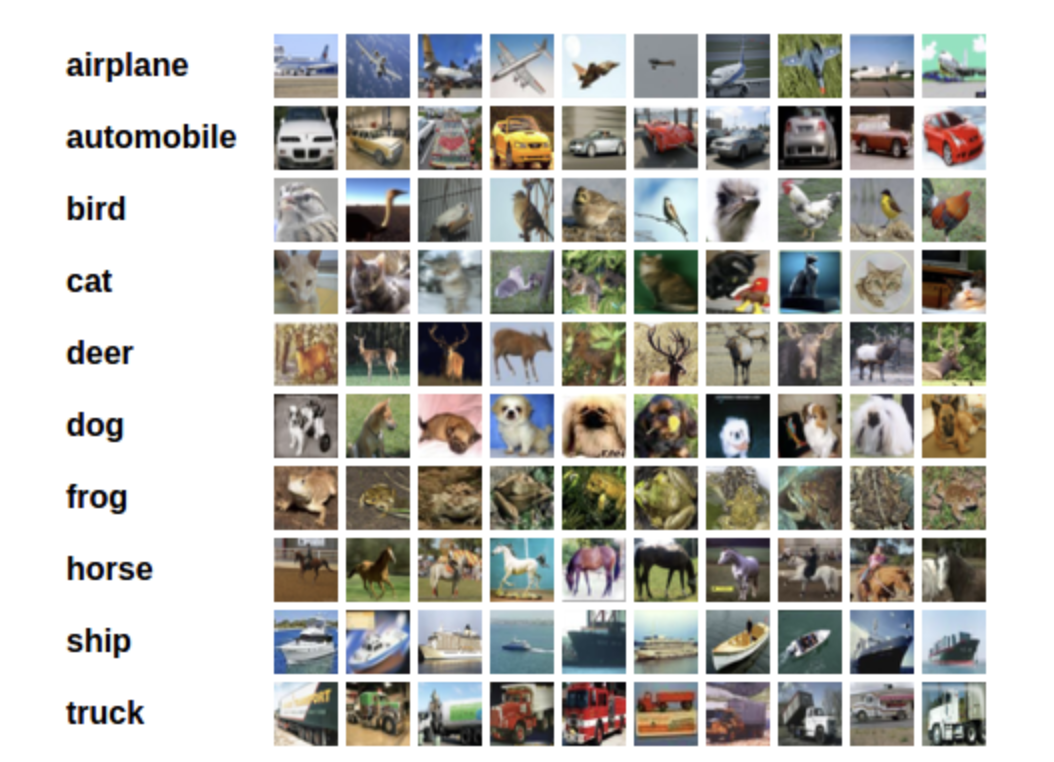

## 분산학습
- 아래 Torch 분산학습 코드를 사용하는 경우
```python
torch.distributed.init_process_group(...)
```
- 아래 코드로 교체해아합니다.
```python
deepspeed.init_distributed()
```

## 초기화
- `deepspeed.initialize`는 분산학습이나 혼합 정밀도 학습을 할 수 있도록 초기화 해줍니다.

```python
model_engine, optimizer, _, _ = deepspeed.initialize(args=cmd_args,
                      model=model,
                      model_parameters=params)
```

In [ ]:
def main(args):
    # Initialize DeepSpeed distributed backend.
    deepspeed.init_distributed()

    ########################################################################
    # Step1. Data Preparation.
    #
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    #
    # Note:
    #     If running on Windows and you get a BrokenPipeError, try setting
    #     the num_worker of torch.utils.data.DataLoader() to 0.
    ########################################################################
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    if torch.distributed.get_rank() != 0:
        # Might be downloading cifar data, let rank 0 download first.
        torch.distributed.barrier()

    # Load or download cifar data.
    trainset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )

    if torch.distributed.get_rank() == 0:
        # Cifar data is downloaded, indicate other ranks can proceed.
        torch.distributed.barrier()

    ########################################################################
    # Step 2. Define the network with DeepSpeed.
    #
    # First, we define a Convolution Neural Network.
    # Then, we define the DeepSpeed configuration dictionary and use it to
    # initialize the DeepSpeed engine.
    ########################################################################
    net = Net(args)

    # Get list of parameters that require gradients.
    parameters = filter(lambda p: p.requires_grad, net.parameters())

    # If using MoE, create separate param groups for each expert.
    if args.moe_param_group:
        parameters = create_moe_param_groups(net)

    # Initialize DeepSpeed to use the following features.
    #   1) Distributed model.
    #   2) Distributed data loader.
    #   3) DeepSpeed optimizer.
    ds_config = get_ds_config(args)
    model_engine, optimizer, trainloader, __ = deepspeed.initialize(
        args=args,
        model=net,
        model_parameters=parameters,
        training_data=trainset,
        config=ds_config,
    )

    # Get the local device name (str) and local rank (int).
    local_device = get_accelerator().device_name(model_engine.local_rank)
    local_rank = model_engine.local_rank

    # For float32, target_dtype will be None so no datatype conversion needed.
    target_dtype = None
    if model_engine.bfloat16_enabled():
        target_dtype = torch.bfloat16
    elif model_engine.fp16_enabled():
        target_dtype = torch.half

    # Define the Classification Cross-Entropy loss function.
    criterion = nn.CrossEntropyLoss()

    ########################################################################
    # Step 3. Train the network.
    #
    # This is when things start to get interesting.
    # We simply have to loop over our data iterator, and feed the inputs to the
    # network and optimize. (DeepSpeed handles the distributed details for us!)
    ########################################################################

    for epoch in range(args.epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            # Get the inputs. ``data`` is a list of [inputs, labels].
            inputs, labels = data[0].to(local_device), data[1].to(local_device)

            # Try to convert to target_dtype if needed.
            if target_dtype != None:
                inputs = inputs.to(target_dtype)

            outputs = model_engine(inputs)
            loss = criterion(outputs, labels)

            model_engine.backward(loss)
            model_engine.step()

            # Print statistics
            running_loss += loss.item()
            if local_rank == 0 and i % args.log_interval == (
                args.log_interval - 1
            ):  # Print every log_interval mini-batches.
                print(
                    f"[{epoch + 1 : d}, {i + 1 : 5d}] loss: {running_loss / args.log_interval : .3f}"
                )
                running_loss = 0.0
    print("Finished Training")

    ########################################################################
    # Step 4. Test the network on the test data.
    ########################################################################
    test(model_engine, testset, local_device, target_dtype)


In [ ]:
if __name__ == "__main__":
    args = add_argument()
    main(args)

[2024-09-16 00:31:43,055] [INFO] [comm.py:652:init_distributed] cdb=None
[2024-09-16 00:31:43,057] [INFO] [comm.py:667:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2024-09-16 00:31:43,745] [INFO] [comm.py:717:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.28.0.12, master_port=29500
[2024-09-16 00:31:43,747] [INFO] [comm.py:683:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


100%|██████████| 170498071/170498071 [00:12<00:00, 13161607.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[2024-09-16 00:32:02,133] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.15.1, git-hash=unknown, git-branch=unknown
[2024-09-16 00:32:02,134] [INFO] [config.py:733:__init__] Config mesh_device None world_size = 1
[2024-09-16 00:32:02,136] [WARNING] [config_utils.py:70:_process_deprecated_field] Config parameter cpu_offload is deprecated use offload_optimizer instead
[2024-09-16 00:32:02,217] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/fused_adam/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


Time to load fused_adam op: 34.43702483177185 seconds
[2024-09-16 00:32:36,662] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
[2024-09-16 00:32:36,663] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-09-16 00:32:36,664] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = FusedAdam
[2024-09-16 00:32:36,665] [INFO] [logging.py:96:log_dist] [Rank 0] Creating fp16 optimizer with dynamic loss scale
[2024-09-16 00:32:36,768] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Final Optimizer = FP16_Optimizer
[2024-09-16 00:32:36,770] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed using configured LR scheduler = WarmupLR
[2024-09-16 00:32:36,770] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed LR Scheduler = <deepspeed.runtime.lr_schedules.WarmupLR object at 0x7b72ac5eacb0>
[2024-09-16 00:32:36,771] [INFO] [logging.py:96:log_dist] [Rank 0] step=0, skip

Loading extension module fused_adam...


[2024-09-16 00:32:36,860] [INFO] [config.py:1003:print]   zero_config .................. stage=0 contiguous_gradients=True reduce_scatter=True reduce_bucket_size=50000000 use_multi_rank_bucket_allreduce=True allgather_partitions=True allgather_bucket_size=50000000 overlap_comm=True load_from_fp32_weights=True elastic_checkpoint=False offload_param=None offload_optimizer=None sub_group_size=1000000000 cpu_offload_param=None cpu_offload_use_pin_memory=None prefetch_bucket_size=50000000 param_persistence_threshold=100000 model_persistence_threshold=9223372036854775807 max_live_parameters=1000000000 max_reuse_distance=1000000000 gather_16bit_weights_on_model_save=False use_all_reduce_for_fetch_params=False stage3_gather_fp16_weights_on_model_save=False ignore_unused_parameters=True legacy_stage1=False round_robin_gradients=False zero_hpz_partition_size=1 zero_quantized_weights=False zero_quantized_nontrainable_weights=False zero_quantized_gradients=False mics_shard_size=-1 mics_hierarchica